   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 1.2 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.5 MB 1.2 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.5 MB 1.2 MB/s eta 0:00:01
   --------------------- ------------------ 0.8/1.5 MB 608.0 kB/s eta 0:00:02
   --------------------- ------------------ 0.8/1.5 MB 608.0 kB/s eta 0:00:02
   --------------------- ------------------ 0.8/1.5 MB 608.0 kB/s eta 0:00:02
   --------------------- ------------------ 0.8/1.5 MB 608.0 kB/s eta 0:00:02
   --------------------- ------------------ 0.8/1.5 MB 608.0 kB/s eta 0:00:02
   --------------------- ------------

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 190, number of negative: 986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1148
[LightGBM] [Info] Number of data points in the train set: 1176, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161565 -> initscore=-1.646632
[LightGBM] [Info] Start training from score -1.646632


c:\Users\Modern\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:29:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


        Algorithm  Accuracy  Precision    Recall  F1-Score   AUC-ROC
6  Support Vector  0.867347   0.900000  0.191489  0.315789  0.812904
0  Light Gradient  0.853741   0.600000  0.255319  0.358209  0.776380
2  Gradient Boost  0.850340   0.588235  0.212766  0.312500  0.793867
3        XG Boost  0.850340   0.578947  0.234043  0.333333  0.759842
7      K Neighbor  0.846939   0.625000  0.106383  0.181818  0.636101
4        AdaBoost  0.843537   0.521739  0.255319  0.342857  0.807477
1   Random Forest  0.836735   0.444444  0.085106  0.142857  0.814670
5   Decision Tree  0.778912   0.333333  0.382979  0.356436  0.618615
8     Naive Bayes  0.615646   0.250000  0.702128  0.368715  0.695581


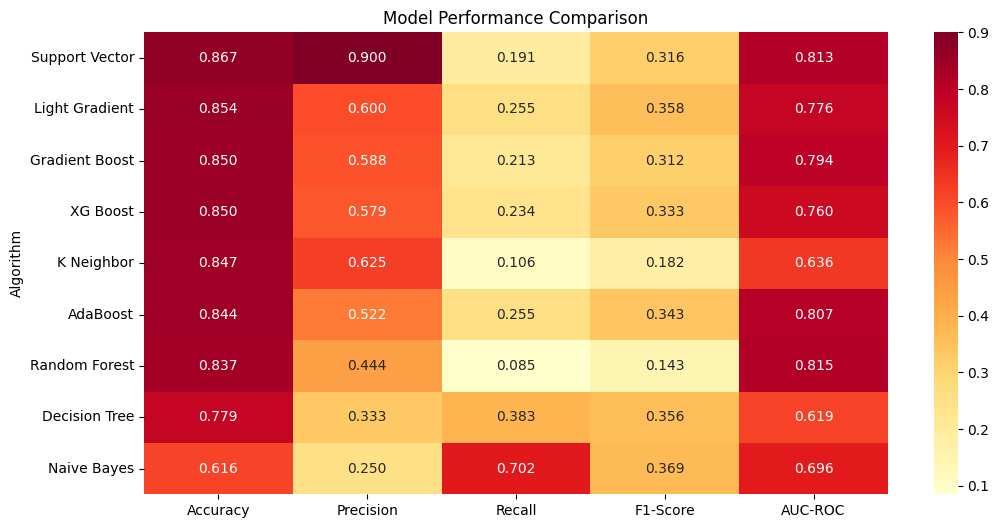

In [2]:
!pip install lightgbm xgboost


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import lightgbm as lgb
import xgboost as xgb

# =======================
# Load Dataset
# =======================
df = pd.read_csv("Employee-Attrition.csv")

# Encode target variable
df['Attrition'] = LabelEncoder().fit_transform(df['Attrition'])  # Yes=1, No=0

# Select features (drop ID-like columns if present)
X = df.drop(columns=['Attrition', 'EmployeeNumber'], errors='ignore')
y = df['Attrition']

# Convert categorical variables
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features for models like SVM, KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =======================
# Define Models
# =======================
models = {
    "Light Gradient": lgb.LGBMClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boost": GradientBoostingClassifier(),
    "XG Boost": xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    "AdaBoost": AdaBoostClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector": SVC(probability=True),
    "K Neighbor": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# =======================
# Train & Evaluate Models
# =======================
results = []

for name, model in models.items():
    if name in ["Support Vector", "K Neighbor", "Naive Bayes"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append([name, acc, prec, rec, f1, auc])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Algorithm", "Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"])

# Sort by Accuracy (or any metric)
results_df = results_df.sort_values(by="Accuracy", ascending=False)

print(results_df)

# =======================
# Pretty Visualization (Optional)
# =======================
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(results_df.set_index("Algorithm"), annot=True, cmap="YlOrRd", fmt=".3f")
plt.title("Model Performance Comparison")
plt.show()
